# TPA WordPress DB Audit

Two-phase analysis of the raw WordPress posts export (`data/RawDB/wp_8i_posts.csv`).

- **Phase 1** — explore the data: understand post types, statuses, and age distribution
- **Phase 2** — categorise every content post as `KEEP`, `DELETE_CANDIDATE`, or `REVIEW`, then export

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timezone
import os

CSV_PATH = 'data/RawDB/wp_8i_posts.csv'
CUTOFF_YEAR = datetime.now(timezone.utc).year - 3

# Canonical WordPress post statuses (rows with numeric values are data artefacts)
WP_STATUSES = {'publish', 'draft', 'private', 'trash', 'pending', 'inherit', 'future'}

# Post types that represent actual site content (everything else is system/operational)
CONTENT_TYPES = {
    'post', 'page', 'whitepaper', 'webinar', 'interviews',
    'toolkits', 'podcast', 'cuttings', 'gated', 'consultations',
    'directory', 'tribe_events', 'tc_events', 'people', 'speakers',
    'nominees', 'product', 'press-releases', 'reports', 'event',
}

df = pd.read_csv(CSV_PATH, low_memory=False)
print(f'Rows: {len(df):,}  |  Columns: {df.shape[1]}')
print(f'Cutoff year: {CUTOFF_YEAR}  (posts published before this are DELETE_CANDIDATE)')
df.head(3)

Rows: 124,505  |  Columns: 11
Cutoff year: 2023  (posts published before this are DELETE_CANDIDATE)


,ID,post_title,post_status,post_type,post_author,post_date,post_modified,post_name,post_parent,menu_order,comment_count
0,194344,The new origin of authorised push payment (APP...,draft,whitepaper,9896,2026-02-18 12:38:05,2026-02-18 12:38:05,NaN,0,0,0
1,194343,JAMESMS100,draft,shop_coupon,14825,2026-02-18 12:32:44,2026-02-18 12:32:44,NaN,0,0,0
2,194333,The Working Group AGM at PAY360,draft,post,10026,2026-02-18 12:28:30,2026-02-18 12:28:30,NaN,0,0,0


---
## Phase 1 — Exploration

### 1.1  Post-type breakdown (all rows)

In [2]:
type_counts = df['post_type'].value_counts()
print(type_counts.to_string())

post_type
tribe_wooticket         44300
shop_order_placehold    38839
attachment              22589
elementor_cf_db          6938
post                     5636
shop_coupon               906
directory                 659
acf-field                 659
product                   636
page                      364
whitepaper                333
speakers                  307
elementor_library         296
people                    260
nav_menu_item             220
tribe_events              206
tribe_rsvp_attendees      177
tc_events                 166
toolkits                  132
nominees                  129
webinar                   111
interviews                105
tc_api_keys                96
consultations              73
podcast                    68
jet-engine                 52
oembed_cache               50
tribe_venue                32
jet-smart-filters          27
cuttings                   22
gated                      18
advanced_ads               16
acf-field-group            13


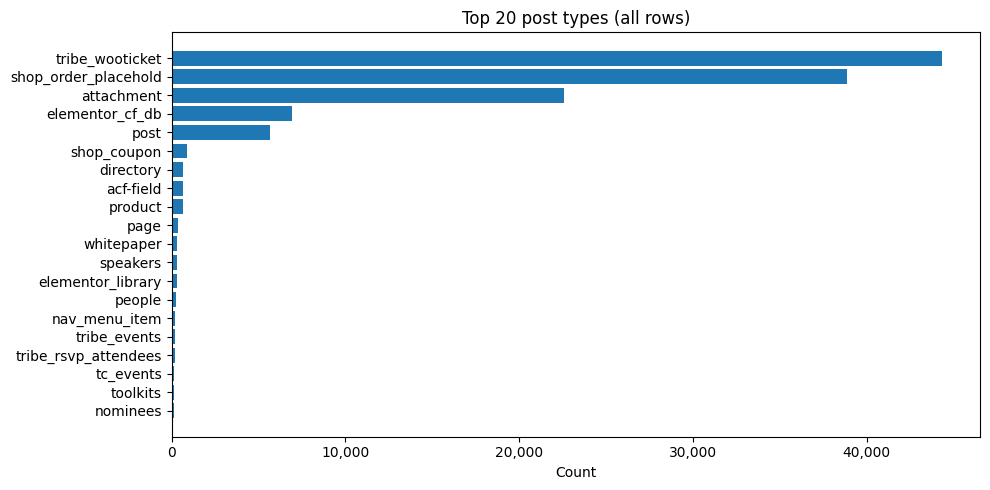

In [3]:
# Plot top 20 post types
top = type_counts.head(20)
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(top.index[::-1], top.values[::-1])
ax.set_xlabel('Count')
ax.set_title('Top 20 post types (all rows)')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

### 1.2  Post-status breakdown

In [4]:
status_counts = df[df['post_status'].isin(WP_STATUSES)]['post_status'].value_counts()
print(status_counts.to_string())

post_status
publish    62005
draft      39246
inherit    22589
private      510
pending      128
trash         26


### 1.3  Focus: content post types

Operational / system types (tickets, orders, attachments, coupons, etc.) are excluded from the content audit.

In [5]:
content = df[df['post_type'].isin(CONTENT_TYPES)].copy()
print(f'Content rows: {len(content):,}')
print()
print(content['post_type'].value_counts().to_string())

Content rows: 9,254

post_type
post              5636
directory          659
product            636
page               364
whitepaper         333
speakers           307
people             260
tribe_events       206
tc_events          166
toolkits           132
nominees           129
webinar            111
interviews         105
consultations       73
podcast             68
cuttings            22
gated               18
press-releases      12
reports              9
event                8


### 1.4  Status breakdown within content types

In [6]:
content_status = content[content['post_status'].isin(WP_STATUSES)]['post_status'].value_counts()
print(content_status.to_string())

post_status
publish    8216
private     509
draft       388
pending     128
trash        13


### 1.5  Age distribution of published content

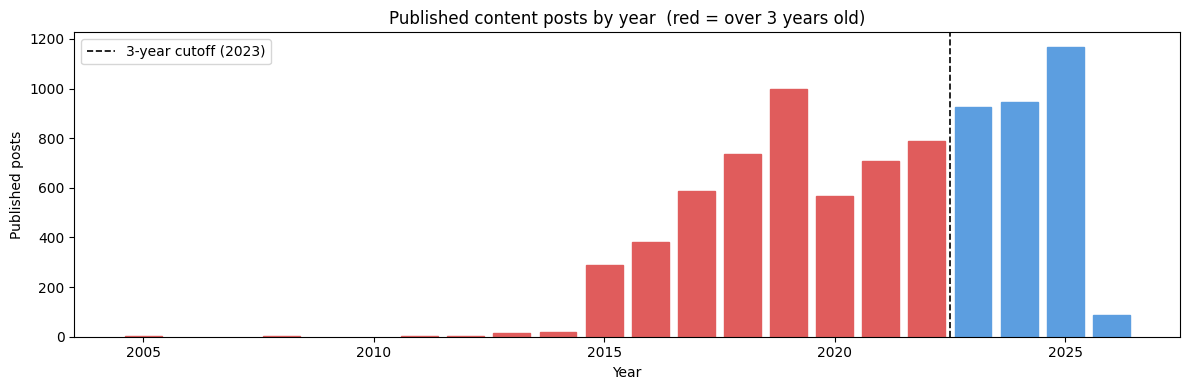

Posts older than 2023: 5,092 / 8,216 (62.0%)


In [7]:
published = content[content['post_status'] == 'publish'].copy()
published['post_date'] = pd.to_datetime(published['post_date'], errors='coerce')
published['year'] = published['post_date'].dt.year

year_counts = published['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(year_counts.index, year_counts.values)

# Shade years older than cutoff
for bar, year in zip(bars, year_counts.index):
    if year < CUTOFF_YEAR:
        bar.set_color('#e05c5c')
    else:
        bar.set_color('#5c9ee0')

ax.axvline(CUTOFF_YEAR - 0.5, color='black', linestyle='--', linewidth=1.2, label=f'3-year cutoff ({CUTOFF_YEAR})')
ax.set_xlabel('Year')
ax.set_ylabel('Published posts')
ax.set_title('Published content posts by year  (red = over 3 years old)')
ax.legend()
plt.tight_layout()
plt.show()

old = published[published['year'] < CUTOFF_YEAR]
print(f'Posts older than {CUTOFF_YEAR}: {len(old):,} / {len(published):,} ({len(old)/len(published)*100:.1f}%)')

### 1.6  Age breakdown by content type

In [8]:
published['age_bucket'] = published['year'].apply(
    lambda y: f'< {CUTOFF_YEAR} (DELETE candidate)' if y < CUTOFF_YEAR else f'>= {CUTOFF_YEAR} (recent)'
)
pivot = published.groupby(['post_type', 'age_bucket']).size().unstack(fill_value=0)
pivot['total'] = pivot.sum(axis=1)
pivot = pivot.sort_values('total', ascending=False)
pivot

age_bucket,< 2023 (DELETE candidate),>= 2023 (recent),total
post_type,,,
post,4189,1266,5455
product,108,520,628
directory,149,237,386
whitepaper,190,114,304
speakers,68,231,299
page,149,127,276
tribe_events,25,161,186
people,0,143,143
webinar,81,30,111


---
## Phase 2 — Categorisation & Export

### 2.1  Categorisation rules

| Condition | Status | Reason |
|---|---|---|
| Non-content post type | `SYSTEM` | Tickets, orders, attachments, coupons — not reviewed |
| `post_status = trash` | `DELETE_CANDIDATE` | Already trashed in WP |
| `post_status = draft` | `REVIEW` | Unpublished draft — decide whether to publish or delete |
| `post_status = private` | `REVIEW` | Private post — verify if intentional |
| Published, `post_date` unknown | `REVIEW` | Can't determine age |
| Published, year < cutoff | `DELETE_CANDIDATE` | Over 3 years old |
| Published, year >= cutoff | `KEEP` | Recent content |

In [9]:
audit = df.copy()
audit['post_date'] = pd.to_datetime(audit['post_date'], errors='coerce')
audit['pub_year'] = audit['post_date'].dt.year

def categorise(row):
    if row['post_type'] not in CONTENT_TYPES:
        return 'SYSTEM', 'Non-content post type - not reviewed'

    status = str(row['post_status']).lower()

    if status == 'trash':
        return 'DELETE_CANDIDATE', 'Already in WP trash'

    if status == 'draft':
        return 'REVIEW', 'Unpublished draft'

    if status == 'private':
        return 'REVIEW', 'Private post - verify if intentional'

    if status == 'pending':
        return 'REVIEW', 'Pending review'

    if pd.isna(row['pub_year']):
        return 'REVIEW', 'Could not determine publish date'

    if row['pub_year'] < CUTOFF_YEAR:
        return 'DELETE_CANDIDATE', f'Published {int(row["pub_year"])} - over 3 years old'

    return 'KEEP', f'Published {int(row["pub_year"])}'


results = audit.apply(categorise, axis=1, result_type='expand')
results.columns = ['audit_status', 'audit_reason']
audit = pd.concat([audit, results], axis=1)

print('Categorisation complete.')
audit['audit_status'].value_counts()

Categorisation complete.


audit_status
SYSTEM              115251
DELETE_CANDIDATE      5105
KEEP                  3124
REVIEW                1025
Name: count, dtype: int64

### 2.2  Content-only summary (excluding SYSTEM rows)

In [10]:
content_audit = audit[audit['audit_status'] != 'SYSTEM'].copy()
summary = content_audit['audit_status'].value_counts()
print(f'Total content posts: {len(content_audit):,}')
print()
print(summary.to_string())
print()
print(f'  DELETE_CANDIDATE: {summary.get("DELETE_CANDIDATE", 0):,}')
print(f'  REVIEW:           {summary.get("REVIEW", 0):,}')
print(f'  KEEP:             {summary.get("KEEP", 0):,}')

Total content posts: 9,254

audit_status
DELETE_CANDIDATE    5105
KEEP                3124
REVIEW              1025

  DELETE_CANDIDATE: 5,105
  REVIEW:           1,025
  KEEP:             3,124


### 2.3  Sample rows per status

In [11]:
cols = ['ID', 'post_title', 'post_type', 'post_status', 'post_date', 'audit_status', 'audit_reason']

for status in ['DELETE_CANDIDATE', 'REVIEW', 'KEEP']:
    subset = content_audit[content_audit['audit_status'] == status][cols].head().copy()
    subset['post_date'] = pd.to_datetime(subset['post_date'], errors='coerce').dt.strftime('%d/%m/%Y')
    print(f'\n--- {status} ({len(content_audit[content_audit["audit_status"] == status]):,} rows) --- sample 5 ---')
    display(subset)


--- DELETE_CANDIDATE (5,105 rows) --- sample 5 ---


,ID,post_title,post_type,post_status,post_date,audit_status,audit_reason
329,152650,PI article template (CLONE - DO NOT WRITE OVER),post,trash,10/02/2026,DELETE_CANDIDATE,Already in WP trash
330,168835,PI article template w/ sidebar (CLONE - DO NOT...,post,trash,10/02/2026,DELETE_CANDIDATE,Already in WP trash
369,193460,Merchant regulation roadmap H1 2026,post,trash,09/02/2026,DELETE_CANDIDATE,Already in WP trash
370,191273,Merchant regulation roadmap H1 2026,post,trash,09/02/2026,DELETE_CANDIDATE,Already in WP trash
589,193050,Jack Testing Templates,post,trash,02/02/2026,DELETE_CANDIDATE,Already in WP trash



--- REVIEW (1,025 rows) --- sample 5 ---


,ID,post_title,post_type,post_status,post_date,audit_status,audit_reason
0,194344,The new origin of authorised push payment (APP...,whitepaper,draft,18/02/2026,REVIEW,Unpublished draft
2,194333,The Working Group AGM at PAY360,post,draft,18/02/2026,REVIEW,Unpublished draft
45,194266,TransferMate completes global rollout of Vivox...,post,pending,17/02/2026,REVIEW,Pending review
48,194262,"Cyber, organized crime, and human trafficking ...",post,pending,17/02/2026,REVIEW,Pending review
84,194191,Erhan Tetik,people,private,16/02/2026,REVIEW,Private post - verify if intentional



--- KEEP (3,124 rows) --- sample 5 ---


,ID,post_title,post_type,post_status,post_date,audit_status,audit_reason
12,194328,ISO 14092:2026 — Climate change adaptation,toolkits,publish,18/02/2026,KEEP,Published 2026
21,193595,The Payments Association Regulations 101 - Onl...,tribe_events,publish,17/02/2026,KEEP,Published 2026
23,194133,The Payments Association Payments 101 - Online...,tribe_events,publish,17/02/2026,KEEP,Published 2026
26,193459,Merchant regulation roadmap H1 2026,post,publish,17/02/2026,KEEP,Published 2026
60,194236,Consultation Paper 25/42 prudential Regime for...,consultations,publish,16/02/2026,KEEP,Published 2026


### 2.4  Export

Two files are written to `data/tpa-audit/YYYY-MM-DD/`:

- **`db_content_audit.csv`** — all content rows with their audit status (excludes SYSTEM types)
- **`db_full_audit.csv`** — every row in the database, including SYSTEM types

In [12]:
date_str = datetime.now().strftime('%Y-%m-%d')
output_dir = os.path.join('data', 'tpa-audit', date_str)
os.makedirs(output_dir, exist_ok=True)

def format_for_export(df_in):
    out = df_in.copy()
    out['url'] = 'https://thepaymentsassociation.org/?p=' + out['ID'].astype(str)
    for col in ('post_date', 'post_modified'):
        parsed = pd.to_datetime(out[col], errors='coerce')
        out[col] = parsed.dt.strftime('%d/%m/%Y')
        out[f'{col}_time'] = parsed.dt.strftime('%H:%M')
    return out

export_cols = ['ID', 'url', 'post_title', 'post_type', 'post_status',
               'post_date', 'post_date_time',
               'post_modified', 'post_modified_time',
               'post_name', 'post_author',
               'audit_status', 'audit_reason']

# Content-only export (sorted: DELETE first, then REVIEW, then KEEP)
status_order = {'DELETE_CANDIDATE': 0, 'REVIEW': 1, 'KEEP': 2}
content_export = content_audit.copy()
content_export['_sort'] = content_export['audit_status'].map(status_order)
content_export = content_export.sort_values(['_sort', 'post_date']).drop(columns='_sort')
content_export = format_for_export(content_export)[export_cols]

content_path = os.path.join(output_dir, 'db_content_audit.csv')
content_export.to_csv(content_path, index=False, encoding='utf-8-sig')
print(f'Content audit saved -> {content_path}  ({len(content_export):,} rows)')

# Full export (all post types)
full_export = audit.copy()
full_export['_sort'] = full_export['audit_status'].map({**status_order, 'SYSTEM': 3})
full_export = full_export.sort_values(['_sort', 'post_date']).drop(columns='_sort')
full_export = format_for_export(full_export)[export_cols]

full_path = os.path.join(output_dir, 'db_full_audit.csv')
full_export.to_csv(full_path, index=False, encoding='utf-8-sig')
print(f'Full audit saved    -> {full_path}  ({len(full_export):,} rows)')

Content audit saved -> data/tpa-audit/2026-02-19/db_content_audit.csv  (9,254 rows)


Full audit saved    -> data/tpa-audit/2026-02-19/db_full_audit.csv  (124,505 rows)
